In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
# imports for creating model and training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# imports handling data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# standard paramenters
batch_size = 16
image_height = 500
image_width = 500

train_path = '/content/drive/MyDrive/D7047E_project/chest_xray/train'
test_path = '/content/drive/MyDrive/D7047E_project/chest_xray/test'
val_path = '/content/drive/MyDrive/D7047E_project/chest_xray/val'

# Pneumonia dectection with deep convolution neural network

## Preparing data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for trian set
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

# Image data generator for test/validation set
test_data_gen = ImageDataGenerator(rescale=1./255)

train = image_gen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

validation = test_data_gen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


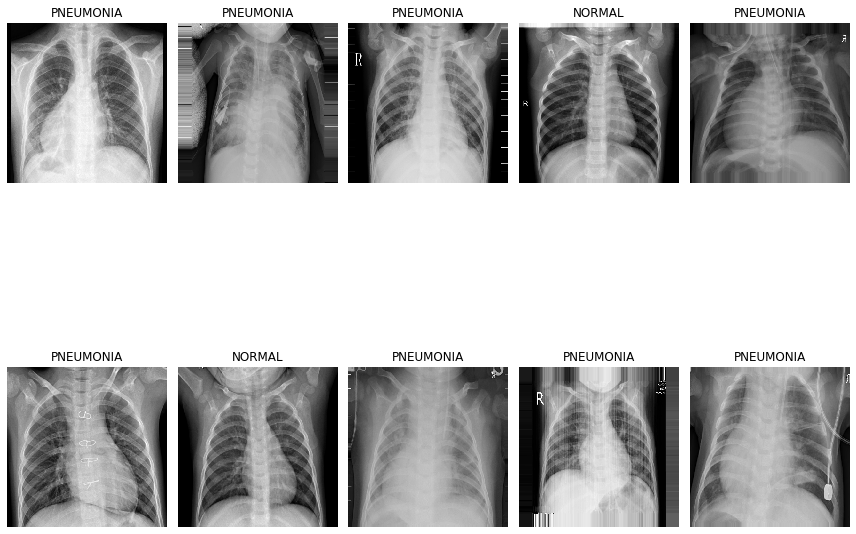

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## Creating the CNN

In [5]:
# model parameters
layer_activation = "relu"
fc_activation = "sigmoid"

optimizer = 'adam'
loss = 'binary_crossentropy'

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=layer_activation, padding='same', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=layer_activation, padding='same', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=layer_activation, padding='same', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=layer_activation, padding='same', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=layer_activation, padding='same', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation=layer_activation, units=128))
model.add(Dense(activation=layer_activation, units=64))
model.add(Dense(activation=fc_activation, units=1))

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        1

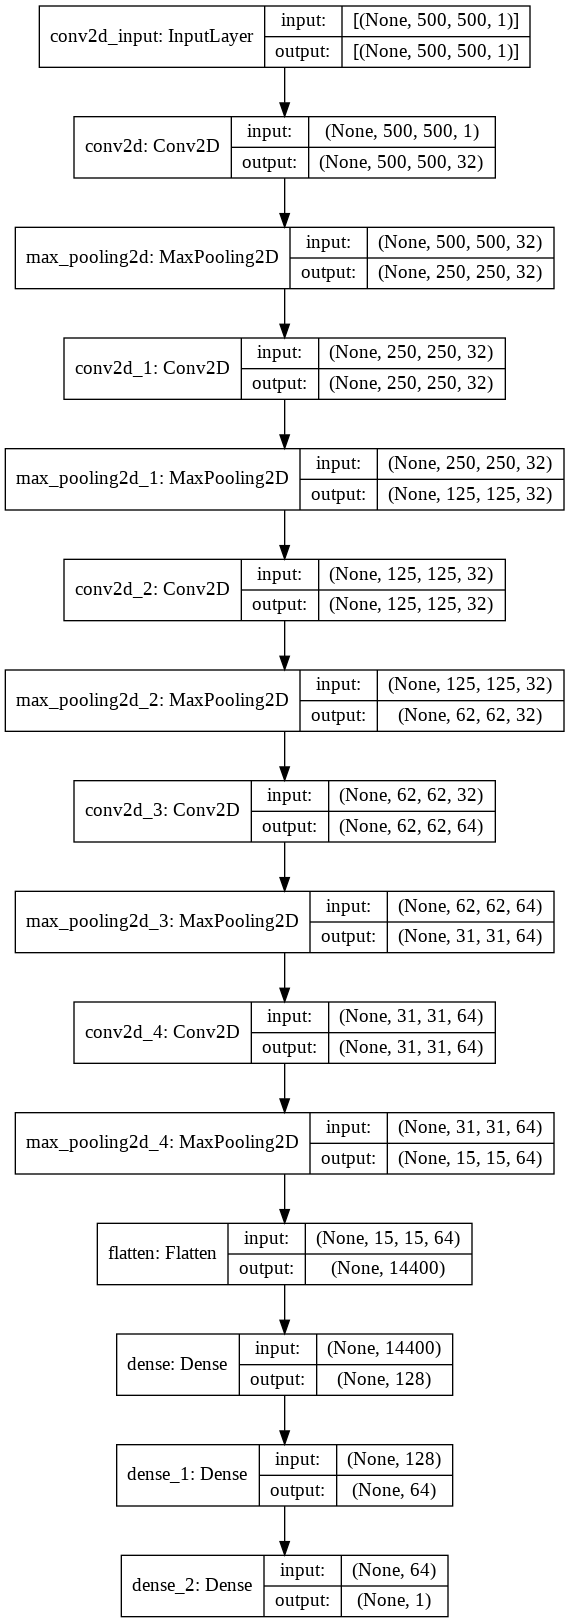

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## Fit the model

In [22]:
# check for available GPU:s
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callback_list = [early, learning_rate_reduction]

In [24]:
# assigning class weights based on the distribution of the dataset
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [25]:
with tf.device('/GPU:0'):
  model.fit(train, epochs=25, validation_data=validation, class_weight=cw, callbacks=callback_list)

Epoch 1/25
326/326 [==============================] - 1371s 4s/step - loss: 0.4688 - accuracy: 0.7427 - val_loss: 0.4950 - val_accuracy: 0.7500
Epoch 2/25
326/326 [==============================] - 134s 410ms/step - loss: 0.2571 - accuracy: 0.8967 - val_loss: 0.4707 - val_accuracy: 0.8125
Epoch 3/25
326/326 [==============================] - 134s 410ms/step - loss: 0.1993 - accuracy: 0.9207 - val_loss: 0.9699 - val_accuracy: 0.6250
Epoch 4/25
326/326 [==============================] - 133s 409ms/step - loss: 0.1782 - accuracy: 0.9301 - val_loss: 0.3533 - val_accuracy: 0.8125
Epoch 5/25
326/326 [==============================] - 133s 407ms/step - loss: 0.1675 - accuracy: 0.9343 - val_loss: 0.9498 - val_accuracy: 0.6250
Epoch 6/25
326/326 [==============================] - 133s 407ms/step - loss: 0.1677 - accuracy: 0.9362 - val_loss: 0.7031 - val_accuracy: 0.7500

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/25
326/326 [=========================

## Evaluate model

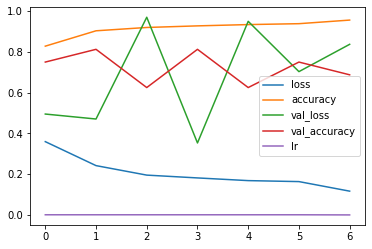

In [26]:
pd.DataFrame(model.history.history).plot()

In [27]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 154s 4s/step - loss: 0.3979 - accuracy: 0.9006
The testing accuracy is : 90.06410241127014 %


In [29]:
preds = model.predict(test,verbose=1)

39/39 [==============================] - 6s 152ms/step


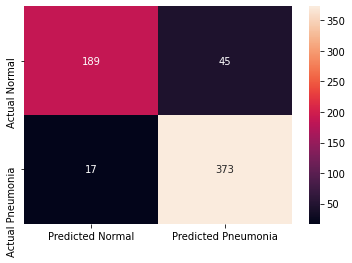

In [30]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [31]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.81      0.86       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



(624, 500, 500, 1)
(624,)


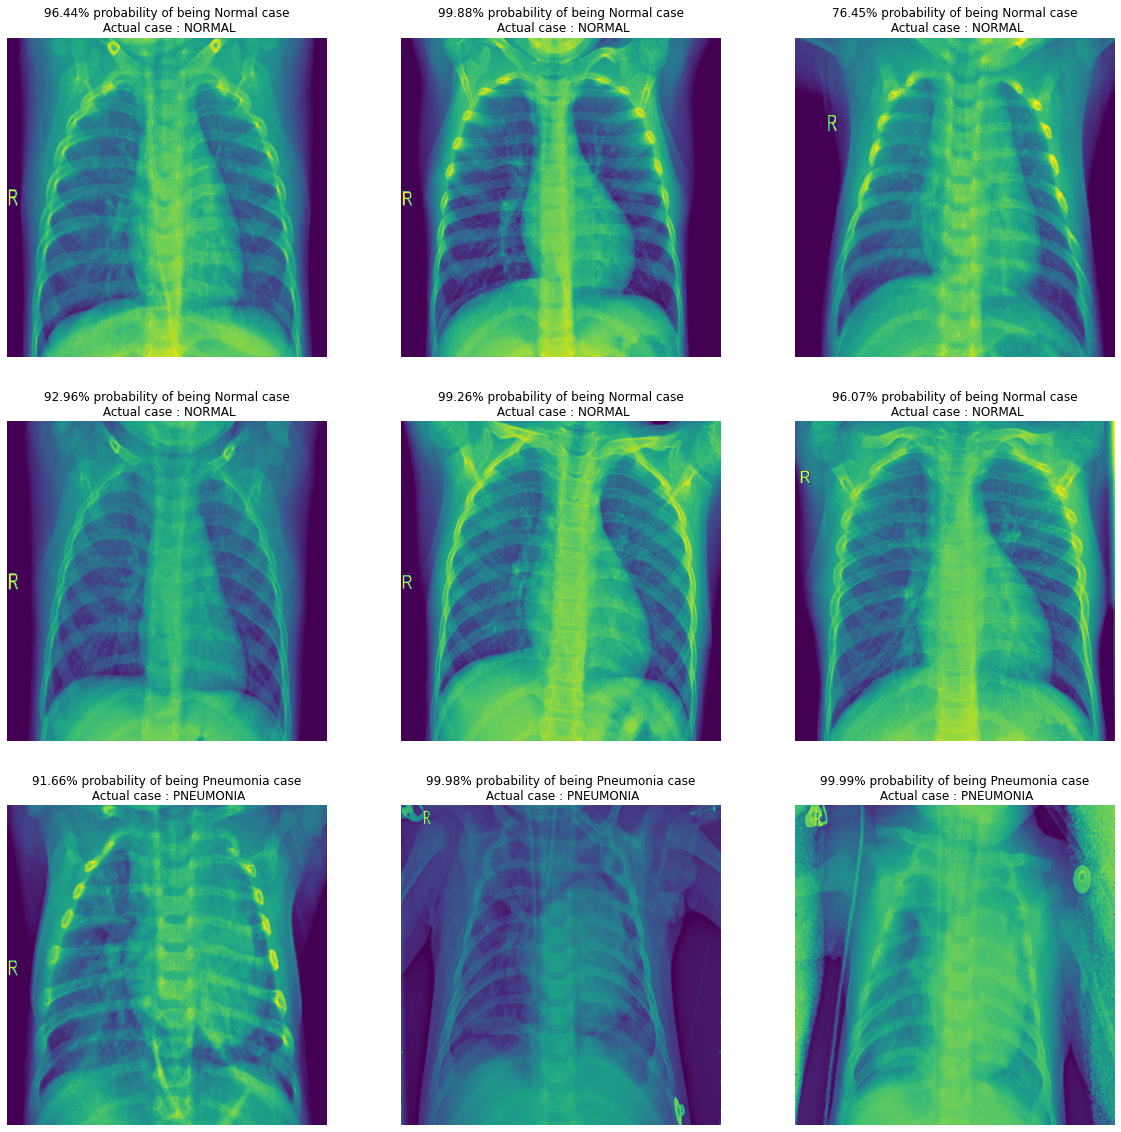

In [36]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 

dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

## Save and load model

In [38]:
save_path = '/content/drive/MyDrive/D7047E_project/saved_models/'
model.save(save_path+model.name)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/D7047E_project/saved_models/sequential_2/assets
